In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
def pam_gray(b):
    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

def qam(num_bits_per_symbol, normalize=True):
    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c

def CreateConstellation(constellation_type, num_bits_per_symbol,normalize=True):
    num_bits_per_symbol = int(num_bits_per_symbol)
    if constellation_type=="qam":
        assert num_bits_per_symbol%2 == 0 and num_bits_per_symbol>0,\
            "num_bits_per_symbol must be a multiple of 2"
        num_bits_per_symbol = int(num_bits_per_symbol)

        points = qam(num_bits_per_symbol, normalize=normalize)
    return points

In [3]:
def show(points, num_bits_per_symbol, labels=True, figsize=(7,7)):
    """Generate a scatter-plot of the constellation.

    Input
    -----
    labels : bool
        If `True`, the bit labels will be drawn next to each constellation
        point. Defaults to `True`.

    figsize : Two-element Tuple, float
        Width and height in inches. Defaults to `(7,7)`.

    Output
    ------
    : matplotlib.figure.Figure
        A handle to a matplot figure object.
    """
    maxval = np.max(np.abs(points))*1.05
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    plt.xlim(-maxval, maxval)
    plt.ylim(-maxval, maxval)
    plt.scatter(np.real(points), np.imag(points))
    ax.set_aspect("equal", adjustable="box")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid(True, which="both", axis="both")
    plt.title("Constellation Plot")
    if labels is True:
        for j, p in enumerate(points):
            plt.annotate(
                np.binary_repr(j, num_bits_per_symbol),
                (np.real(p), np.imag(p))
            )
    return fig

In [4]:
NUM_BITS_PER_SYMBOL = 4 # QPSK: 2, QAM16
points = CreateConstellation("qam", NUM_BITS_PER_SYMBOL)
points.shape

(16,)

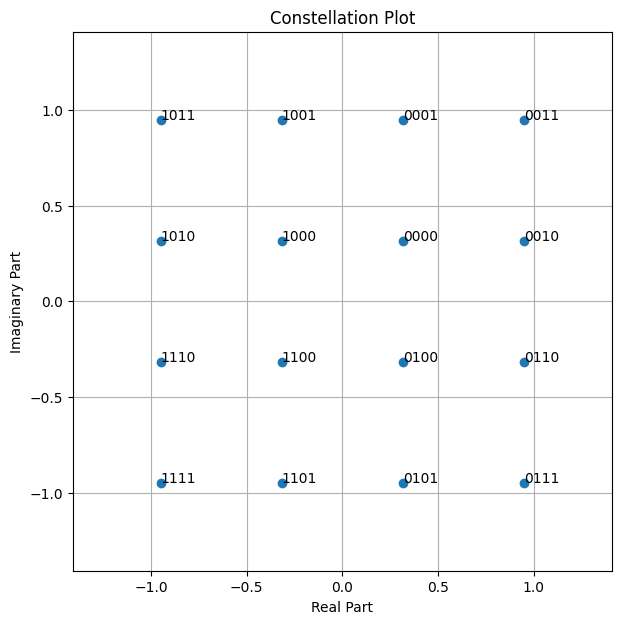

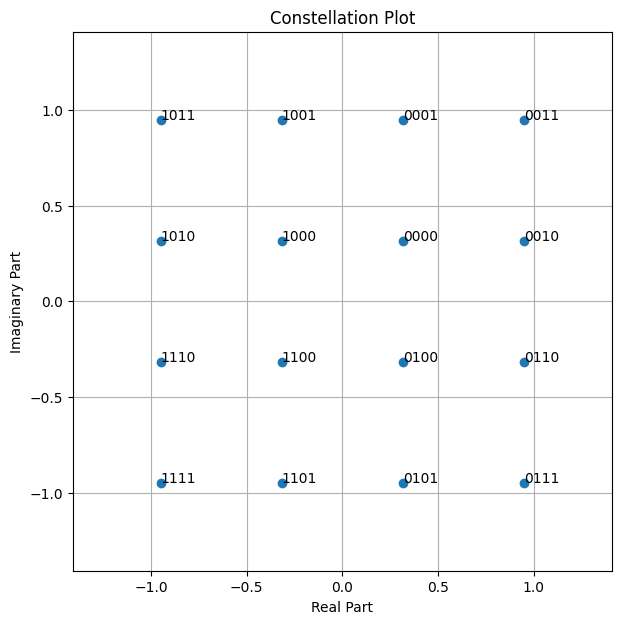

In [5]:
show(points, NUM_BITS_PER_SYMBOL)

In [6]:
def BinarySource(shape):
    return np.random.randint(2, size=shape).astype(np.float32)

In [7]:
def complex_normal(shape, var=1.0):
    stddev = np.sqrt(var/2)
    xr = np.random.normal(loc=0.0, scale=stddev, size=shape)
    xi = np.random.normal(loc=0.0, scale=stddev, size=shape)
    x = xr + 1j*xi
    return x

In [8]:
class Mapper:
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 #dtype=tf.complex64,
                 #**kwargs
                ):
          self.num_bits_per_symbol = num_bits_per_symbol
          self.binary_base = 2**np.arange(num_bits_per_symbol-1, -1, -1, dtype=int) #array([2, 1], dtype=int32)
          self.points = CreateConstellation(constellation_type, num_bits_per_symbol) #(4,)
    
    def create_symbol(self, inputs):
        #inputs: (64, 1024) #batch_size, bits len
        new_shape = [-1] + [int(inputs.shape[-1] / self.num_bits_per_symbol), self.num_bits_per_symbol] #[-1, 512, 2]
        reinputs_reshaped = np.reshape(inputs, new_shape) #(64, 512, 2)
        # Convert the last dimension to an integer
        int_rep = reinputs_reshaped * self.binary_base #(64, 512, 2)
        int_rep = np.sum(int_rep, axis=-1) #(64, 512)
        int_rep = int_rep.astype(np.int32)
        #print(int_rep.shape)
        # Map integers to constellation symbols
        #x = tf.gather(self.points, int_rep, axis=0)
        symbs_list = [self.points[val_int] for val_int in int_rep]
        symbols=np.array(symbs_list) #(64, 512) complex64
        #print(symbols.dtype)
        return symbols

In [9]:
def ebnodb2no(ebno_db, num_bits_per_symbol, coderate):
    r"""Compute the noise variance `No` for a given `Eb/No` in dB.
    Input
    -----
    ebno_db : float
        The `Eb/No` value in dB.

    num_bits_per_symbol : int
        The number of bits per symbol.

    coderate : float
        The coderate used.

    Output
    ------
    : float
        The value of :math:`N_o` in linear scale.
    """
    #ebno = tf.math.pow(tf.cast(10., dtype), ebno_db/10.)
    ebno = np.power(10, ebno_db/10.0)
    energy_per_symbol = 1
    tmp= (ebno * coderate * float(num_bits_per_symbol)) / float(energy_per_symbol)
    n0 = 1/tmp
    return n0

In [10]:
# custom dataset
class ComplexDataset(Dataset):
    def __init__(self, num_bits_per_symbol, Frame_SIZE=64, Blocklength = 1024, DB_MIN=-10, DB_MAX=20, totaldbs=2000, constellation_type="qam", data_type=np.complex64):
        self.points = CreateConstellation(constellation_type, num_bits_per_symbol)
        print(self.points.shape) #(4,) complex64
        self.shape = ([Frame_SIZE, Blocklength])# Blocklength [64, 1024]
        self.constellation_type = constellation_type
        self.num_bits_per_symbol = num_bits_per_symbol
        self.data_type = data_type
        self.mapper=Mapper(constellation_type=constellation_type, num_bits_per_symbol=num_bits_per_symbol)

        ebno_dbs=np.linspace(DB_MIN, DB_MAX, totaldbs)
        np.random.shuffle(ebno_dbs)
        self.ebno_dbs = ebno_dbs
    
    def __getitem__(self, index):
        ebno_db = self.ebno_dbs[index]

        bits = BinarySource(self.shape)
        #print("Shape of bits: ", bits.shape) #(64, 1024)

        x=self.mapper.create_symbol(bits) #(64, 512) complex64

        n0=ebnodb2no(ebno_db=ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=1.0) #scalar 0.05
        noise=complex_normal(x.shape, 1.0) #(64, 512) complex128
        #print(noise.dtype)
        noise = noise.astype(self.data_type)
        noise *= np.sqrt(n0) 
        y=x+noise #(64, 512)
        signal_complex = torch.from_numpy(y)

        batch={}
        batch['samples']=signal_complex #(64, 512)
        batch['labels']=bits #(64, 1024)
        return batch
    
    def __len__(self):
        return len(self.ebno_dbs)

In [11]:
NUM_BITS_PER_SYMBOL = 4
BATCH_SIZE = 32
Frame_SIZE = 64
Blocklength = 1024
DB_MIN = -20
DB_MAX = 20
dataset = ComplexDataset(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, Frame_SIZE=Frame_SIZE, Blocklength=Blocklength, DB_MIN=DB_MIN, DB_MAX=DB_MAX, totaldbs=BATCH_SIZE*100)

(16,)


In [12]:
onesample = dataset[0]

In [13]:
onesample.keys()

dict_keys(['samples', 'labels'])

In [14]:
onesample['samples'].shape

torch.Size([64, 256])

In [15]:
onesample['labels'].shape

(64, 1024)

In [16]:
# train, validation and test split
train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size
train_set, val_set= torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=True, pin_memory=True)


In [17]:
onebatch = next(iter(val_loader))

In [18]:
onebatch['samples'].shape

torch.Size([1, 64, 256])

In [19]:
onebatch = next(iter(train_loader))

In [20]:
onebatch['samples'].shape

torch.Size([32, 64, 256])

In [21]:
gpuid=0
if torch.cuda.is_available():
    device = torch.device('cuda:'+str(gpuid))  # CUDA GPU 0
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [22]:
class MoreImprovedModelDeep(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(MoreImprovedModelDeep, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=scale * num_bits_per_symbol)
        self.linear2 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=scale * num_bits_per_symbol)
        self.linear3 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs
        z = torch.stack([y.real, y.imag], dim=0)
        z = z.permute(1, 2, 3, 0)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = nn.Sigmoid()(z)
        z = z.flatten(-2, -1)
        return z

In [23]:
model = MoreImprovedModelDeep(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [24]:
output = model(onebatch['samples']) #[32, 64, 512] =>[32, 64, 1024]

In [25]:
output.shape

torch.Size([32, 64, 1024])

In [26]:
output.dtype

torch.float32

In [27]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.4)

In [28]:
test=torch.tensor([0,0,0,1,1,1], dtype=torch.float)

In [29]:
loss_fn(test,test)

tensor(0.)

In [30]:
onebatch['labels'].dtype

torch.float32

In [31]:
loss_fn(output,onebatch['labels'])

tensor(0.6990, grad_fn=<BinaryCrossEntropyBackward0>)

In [32]:
import os
trainoutput=os.path.join('output','exp0212')
os.makedirs(trainoutput, exist_ok=True)
print("Trainoutput folder:", trainoutput)

Trainoutput folder: output/exp0212


In [33]:
train_losses = []
val_losses = []
val_BERs = []

In [34]:
model=model.to(device)

In [35]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/80 [00:00<?, ?it/s]

100%|██████████| 640/640 [00:03<00:00, 202.06it/s]


Epoch [1/20], Loss: 0.6638, Val Loss: 0.6180, Val BER: 0.2904


100%|██████████| 640/640 [00:02<00:00, 243.47it/s]


Epoch [2/20], Loss: 0.5861, Val Loss: 0.4686, Val BER: 0.2147


100%|██████████| 640/640 [00:02<00:00, 249.75it/s]


Epoch [3/20], Loss: 0.5544, Val Loss: 0.4186, Val BER: 0.2011


100%|██████████| 640/640 [00:02<00:00, 246.92it/s]


Epoch [4/20], Loss: 0.5254, Val Loss: 0.3396, Val BER: 0.1942


100%|██████████| 640/640 [00:02<00:00, 249.40it/s]


Epoch [5/20], Loss: 0.4929, Val Loss: 0.4544, Val BER: 0.1872


100%|██████████| 640/640 [00:02<00:00, 249.00it/s]


Epoch [6/20], Loss: 0.4635, Val Loss: 0.2185, Val BER: 0.1836


100%|██████████| 640/640 [00:02<00:00, 244.90it/s]


Epoch [7/20], Loss: 0.4446, Val Loss: 0.1653, Val BER: 0.1835


100%|██████████| 640/640 [00:02<00:00, 247.80it/s]


Epoch [8/20], Loss: 0.4360, Val Loss: 0.2267, Val BER: 0.1833


100%|██████████| 640/640 [00:02<00:00, 246.67it/s]


Epoch [9/20], Loss: 0.4317, Val Loss: 0.7868, Val BER: 0.1835


100%|██████████| 640/640 [00:02<00:00, 251.03it/s]


Epoch [10/20], Loss: 0.4291, Val Loss: 0.1273, Val BER: 0.1834


100%|██████████| 640/640 [00:02<00:00, 246.54it/s]


Epoch [11/20], Loss: 0.4274, Val Loss: 0.6387, Val BER: 0.1840


100%|██████████| 640/640 [00:02<00:00, 251.53it/s]


Epoch [12/20], Loss: 0.4257, Val Loss: 0.5883, Val BER: 0.1832


100%|██████████| 640/640 [00:02<00:00, 246.44it/s]


Epoch [13/20], Loss: 0.4247, Val Loss: 0.7944, Val BER: 0.1831


100%|██████████| 640/640 [00:02<00:00, 244.07it/s]


Epoch [14/20], Loss: 0.4239, Val Loss: 0.1065, Val BER: 0.1832


100%|██████████| 640/640 [00:02<00:00, 252.01it/s]


Epoch [15/20], Loss: 0.4234, Val Loss: 0.1589, Val BER: 0.1832


100%|██████████| 640/640 [00:02<00:00, 245.83it/s]


Epoch [16/20], Loss: 0.4226, Val Loss: 0.3156, Val BER: 0.1832


100%|██████████| 640/640 [00:02<00:00, 249.06it/s]


Epoch [17/20], Loss: 0.4223, Val Loss: 0.7585, Val BER: 0.1832


100%|██████████| 640/640 [00:02<00:00, 245.02it/s]


Epoch [18/20], Loss: 0.4220, Val Loss: 0.7782, Val BER: 0.1830


100%|██████████| 640/640 [00:02<00:00, 249.26it/s]


Epoch [19/20], Loss: 0.4213, Val Loss: 0.7788, Val BER: 0.1831


100%|██████████| 640/640 [00:02<00:00, 247.44it/s]

Epoch [20/20], Loss: 0.4210, Val Loss: 0.1624, Val BER: 0.1833


In [36]:
# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
modelsave_path = os.path.join(trainoutput, 'model_test_data.pth')
torch.save(checkpoint, modelsave_path)

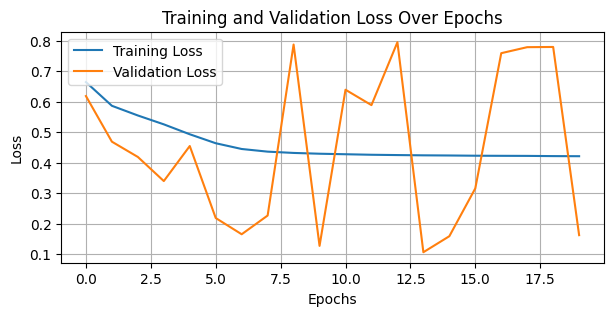

In [37]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)

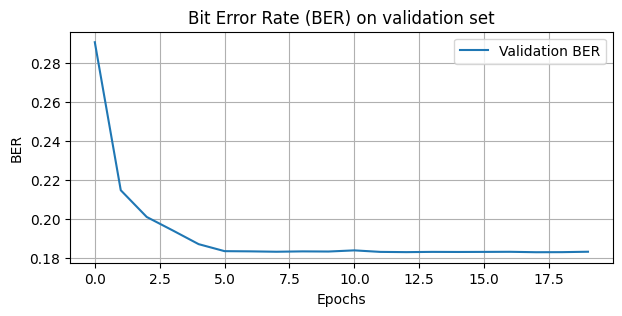

In [38]:
# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(val_BERs, label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set')
plt.grid(True)

# Playing with the Bits per symbols and Noise Ratio

## 1

In [39]:
NUM_BITS_PER_SYMBOL = 2
BATCH_SIZE = 32
Frame_SIZE = 64
Blocklength = 1024
DB_MIN = -20
DB_MAX = 20
dataset = ComplexDataset(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, Frame_SIZE=Frame_SIZE, Blocklength=Blocklength, DB_MIN=DB_MIN, DB_MAX=DB_MAX, totaldbs=BATCH_SIZE*100)

(4,)


In [40]:
onesample = dataset[0]

In [41]:
onesample.keys()

dict_keys(['samples', 'labels'])

In [42]:
onesample['samples'].shape

torch.Size([64, 512])

In [43]:
onesample['labels'].shape

(64, 1024)

In [44]:
# train, validation and test split
train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size
train_set, val_set= torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=True, pin_memory=True)


In [45]:
onebatch = next(iter(val_loader))

In [46]:
onebatch['samples'].shape

torch.Size([1, 64, 512])

In [47]:
onebatch = next(iter(train_loader))

In [48]:
onebatch['samples'].shape

torch.Size([32, 64, 512])

In [49]:
gpuid=0
if torch.cuda.is_available():
    device = torch.device('cuda:'+str(gpuid))  # CUDA GPU 0
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [50]:
class MoreImprovedModelDeep(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(MoreImprovedModelDeep, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=scale * num_bits_per_symbol)
        self.linear2 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=scale * num_bits_per_symbol)
        self.linear3 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs
        z = torch.stack([y.real, y.imag], dim=0)
        z = z.permute(1, 2, 3, 0)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = nn.Sigmoid()(z)
        z = z.flatten(-2, -1)
        return z

In [51]:
model = MoreImprovedModelDeep(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [52]:
output = model(onebatch['samples']) #[32, 64, 512] =>[32, 64, 1024]

In [53]:
output.shape

torch.Size([32, 64, 1024])

In [54]:
output.dtype

torch.float32

In [55]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.4)

In [56]:
test=torch.tensor([0,0,0,1,1,1], dtype=torch.float)

In [57]:
loss_fn(test,test)

tensor(0.)

In [58]:
onebatch['labels'].dtype

torch.float32

In [59]:
loss_fn(output,onebatch['labels'])

tensor(0.6992, grad_fn=<BinaryCrossEntropyBackward0>)

In [60]:
import os
trainoutput=os.path.join('output','exp0212')
os.makedirs(trainoutput, exist_ok=True)
print("Trainoutput folder:", trainoutput)

Trainoutput folder: output/exp0212


In [61]:
train_losses = []
val_losses = []
val_BERs = []

In [62]:
model=model.to(device)

In [63]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")


100%|██████████| 640/640 [00:03<00:00, 165.70it/s]


Epoch [1/20], Loss: 0.6205, Val Loss: 0.3632, Val BER: 0.1638


100%|██████████| 640/640 [00:03<00:00, 193.67it/s]


Epoch [2/20], Loss: 0.4378, Val Loss: 0.5371, Val BER: 0.1620


100%|██████████| 640/640 [00:03<00:00, 192.19it/s]


Epoch [3/20], Loss: 0.3821, Val Loss: 0.5091, Val BER: 0.1630


100%|██████████| 640/640 [00:03<00:00, 189.81it/s]


Epoch [4/20], Loss: 0.3676, Val Loss: 0.1882, Val BER: 0.1620


100%|██████████| 640/640 [00:03<00:00, 186.91it/s]


Epoch [5/20], Loss: 0.3622, Val Loss: 0.0609, Val BER: 0.1616


100%|██████████| 640/640 [00:03<00:00, 188.34it/s]


Epoch [6/20], Loss: 0.3592, Val Loss: 0.7452, Val BER: 0.1611


100%|██████████| 640/640 [00:03<00:00, 188.60it/s]


Epoch [7/20], Loss: 0.3574, Val Loss: 0.6756, Val BER: 0.1608


100%|██████████| 640/640 [00:03<00:00, 189.70it/s]


Epoch [8/20], Loss: 0.3563, Val Loss: 0.0509, Val BER: 0.1608


100%|██████████| 640/640 [00:03<00:00, 189.20it/s]


Epoch [9/20], Loss: 0.3557, Val Loss: 0.2459, Val BER: 0.1609


100%|██████████| 640/640 [00:03<00:00, 182.19it/s]


Epoch [10/20], Loss: 0.3552, Val Loss: 0.7525, Val BER: 0.1608


100%|██████████| 640/640 [00:03<00:00, 190.04it/s]


Epoch [11/20], Loss: 0.3546, Val Loss: 0.0521, Val BER: 0.1606


100%|██████████| 640/640 [00:03<00:00, 189.18it/s]


Epoch [12/20], Loss: 0.3542, Val Loss: 0.0328, Val BER: 0.1605


100%|██████████| 640/640 [00:03<00:00, 191.01it/s]


Epoch [13/20], Loss: 0.3536, Val Loss: 0.0489, Val BER: 0.1605


100%|██████████| 640/640 [00:03<00:00, 190.77it/s]


Epoch [14/20], Loss: 0.3532, Val Loss: 0.2367, Val BER: 0.1605


100%|██████████| 640/640 [00:03<00:00, 186.44it/s]


Epoch [15/20], Loss: 0.3529, Val Loss: 0.6552, Val BER: 0.1604


100%|██████████| 640/640 [00:03<00:00, 189.61it/s]


Epoch [16/20], Loss: 0.3525, Val Loss: 0.1296, Val BER: 0.1602


100%|██████████| 640/640 [00:03<00:00, 182.01it/s]


Epoch [17/20], Loss: 0.3523, Val Loss: 0.7491, Val BER: 0.1603


100%|██████████| 640/640 [00:03<00:00, 192.24it/s]


Epoch [18/20], Loss: 0.3520, Val Loss: 0.7431, Val BER: 0.1604


100%|██████████| 640/640 [00:03<00:00, 188.57it/s]


Epoch [19/20], Loss: 0.3518, Val Loss: 0.1846, Val BER: 0.1603


100%|██████████| 640/640 [00:03<00:00, 189.27it/s]

Epoch [20/20], Loss: 0.3515, Val Loss: 0.0724, Val BER: 0.1604


In [64]:
# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
modelsave_path = os.path.join(trainoutput, 'model_test_data_1.pth')
torch.save(checkpoint, modelsave_path)

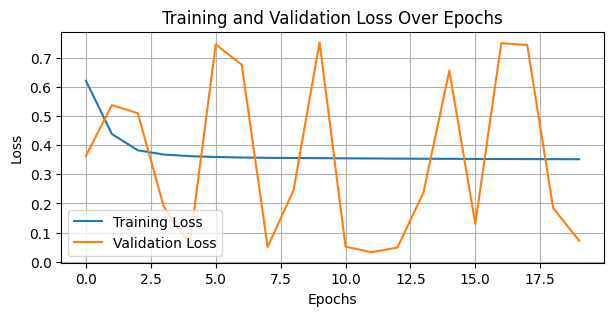

In [65]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)

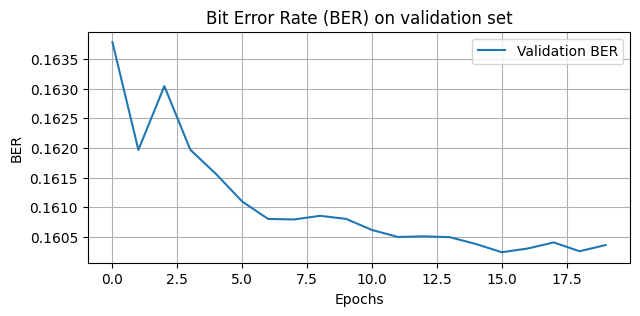

In [66]:
# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(val_BERs, label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set')
plt.grid(True)

## 2

In [67]:
NUM_BITS_PER_SYMBOL = 8
BATCH_SIZE = 32
Frame_SIZE = 64
Blocklength = 1024
DB_MIN = -20
DB_MAX = 20
dataset = ComplexDataset(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, Frame_SIZE=Frame_SIZE, Blocklength=Blocklength, DB_MIN=DB_MIN, DB_MAX=DB_MAX, totaldbs=BATCH_SIZE*100)

(256,)


In [68]:
onesample = dataset[0]

In [69]:
onesample.keys()

dict_keys(['samples', 'labels'])

In [70]:
onesample['samples'].shape

torch.Size([64, 128])

In [71]:
onesample['labels'].shape

(64, 1024)

In [72]:
# train, validation and test split
train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size
train_set, val_set= torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=True, pin_memory=True)


In [73]:
onebatch = next(iter(val_loader))

In [74]:
onebatch['samples'].shape

torch.Size([1, 64, 128])

In [75]:
onebatch = next(iter(train_loader))

In [76]:
onebatch['samples'].shape

torch.Size([32, 64, 128])

In [77]:
gpuid=0
if torch.cuda.is_available():
    device = torch.device('cuda:'+str(gpuid))  # CUDA GPU 0
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [78]:
class MoreImprovedModelDeep(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=512):
        super(MoreImprovedModelDeep, self).__init__()
        scale = 8
        self.linear1 = nn.Linear(in_features=2, out_features=scale * num_bits_per_symbol)
        self.linear2 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=scale * num_bits_per_symbol)
        self.linear3 = nn.Linear(in_features=scale * num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs
        z = torch.stack([y.real, y.imag], dim=0)
        z = z.permute(1, 2, 3, 0)
        z = self.linear1(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear2(z)
        z = self.activation(z)
        z = self.linear3(z)
        z = nn.Sigmoid()(z)
        z = z.flatten(-2, -1)
        return z

In [79]:
model = MoreImprovedModelDeep(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [80]:
output = model(onebatch['samples']) #[32, 64, 512] =>[32, 64, 1024]

In [81]:
output.shape

torch.Size([32, 64, 1024])

In [82]:
output.dtype

torch.float32

In [83]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.4)

In [84]:
test=torch.tensor([0,0,0,1,1,1], dtype=torch.float)

In [85]:
loss_fn(test,test)

tensor(0.)

In [86]:
onebatch['labels'].dtype

torch.float32

In [87]:
loss_fn(output,onebatch['labels'])

tensor(0.6939, grad_fn=<BinaryCrossEntropyBackward0>)

In [88]:
import os
trainoutput=os.path.join('output','exp0212')
os.makedirs(trainoutput, exist_ok=True)
print("Trainoutput folder:", trainoutput)

Trainoutput folder: output/exp0212


In [89]:
train_losses = []
val_losses = []
val_BERs = []

In [90]:
model=model.to(device)

In [91]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")


100%|██████████| 640/640 [00:02<00:00, 237.46it/s]


Epoch [1/20], Loss: 0.6764, Val Loss: 0.6366, Val BER: 0.3854


100%|██████████| 640/640 [00:02<00:00, 303.37it/s]


Epoch [2/20], Loss: 0.6292, Val Loss: 0.5924, Val BER: 0.3387


100%|██████████| 640/640 [00:02<00:00, 307.40it/s]


Epoch [3/20], Loss: 0.6135, Val Loss: 0.8351, Val BER: 0.3402


100%|██████████| 640/640 [00:02<00:00, 306.75it/s]


Epoch [4/20], Loss: 0.6045, Val Loss: 0.5371, Val BER: 0.3361


100%|██████████| 640/640 [00:02<00:00, 294.49it/s]


Epoch [5/20], Loss: 0.5971, Val Loss: 0.5214, Val BER: 0.3298


100%|██████████| 640/640 [00:02<00:00, 298.39it/s]


Epoch [6/20], Loss: 0.5904, Val Loss: 0.8111, Val BER: 0.3229


100%|██████████| 640/640 [00:02<00:00, 303.97it/s]


Epoch [7/20], Loss: 0.5843, Val Loss: 0.5759, Val BER: 0.3161


100%|██████████| 640/640 [00:02<00:00, 307.43it/s]


Epoch [8/20], Loss: 0.5787, Val Loss: 0.5109, Val BER: 0.3123


100%|██████████| 640/640 [00:02<00:00, 294.00it/s]


Epoch [9/20], Loss: 0.5732, Val Loss: 0.6391, Val BER: 0.3089


100%|██████████| 640/640 [00:02<00:00, 301.13it/s]


Epoch [10/20], Loss: 0.5680, Val Loss: 0.7025, Val BER: 0.3085


100%|██████████| 640/640 [00:02<00:00, 308.13it/s]


Epoch [11/20], Loss: 0.5635, Val Loss: 0.7016, Val BER: 0.3061


100%|██████████| 640/640 [00:02<00:00, 306.91it/s]


Epoch [12/20], Loss: 0.5600, Val Loss: 0.4522, Val BER: 0.3053


100%|██████████| 640/640 [00:02<00:00, 294.89it/s]


Epoch [13/20], Loss: 0.5573, Val Loss: 0.5047, Val BER: 0.3002


100%|██████████| 640/640 [00:02<00:00, 299.06it/s]


Epoch [14/20], Loss: 0.5552, Val Loss: 0.5345, Val BER: 0.2975


100%|██████████| 640/640 [00:02<00:00, 306.64it/s]


Epoch [15/20], Loss: 0.5533, Val Loss: 0.7517, Val BER: 0.2933


100%|██████████| 640/640 [00:02<00:00, 306.72it/s]


Epoch [16/20], Loss: 0.5518, Val Loss: 0.4237, Val BER: 0.2901


100%|██████████| 640/640 [00:02<00:00, 302.88it/s]


Epoch [17/20], Loss: 0.5501, Val Loss: 0.4199, Val BER: 0.2867


100%|██████████| 640/640 [00:02<00:00, 299.22it/s]


Epoch [18/20], Loss: 0.5484, Val Loss: 0.5613, Val BER: 0.2827


100%|██████████| 640/640 [00:02<00:00, 304.56it/s]


Epoch [19/20], Loss: 0.5468, Val Loss: 0.4456, Val BER: 0.2808


100%|██████████| 640/640 [00:02<00:00, 309.30it/s]

Epoch [20/20], Loss: 0.5453, Val Loss: 0.7461, Val BER: 0.2773


In [92]:
# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
modelsave_path = os.path.join(trainoutput, 'model_test_data_1.pth')
torch.save(checkpoint, modelsave_path)

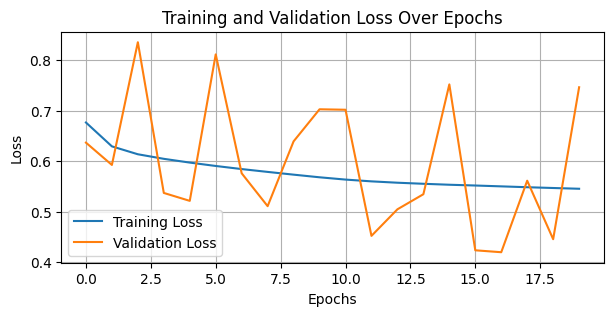

In [93]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)

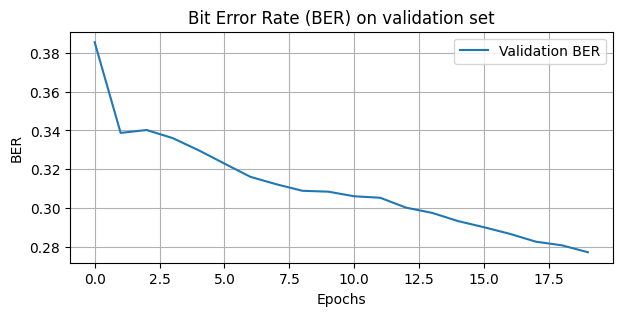

In [94]:
# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(val_BERs, label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set')
plt.grid(True)